In [1]:
import xarray as xr
import xgcm as xgcm
import numpy as np
import gsw
import cmocean as cm
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings('ignore')

# In this notebook...

You will examine output from the CARIB12 simulation or a CARIB12 simulation of your own. The notebook focuses n two simple analyses relevant to model development and validation: \
1- Calculating and plotting Eddy Kinetic Energy to examine mesoscale variability of flow. \
2- Plotting a Temperature-Salinity diagram to examine water mass properties. 

You will either access the original CARIB12 simulation output or recreate your own CARIB12 simulation using CROCODASH. 

There are several prompts along the notebook to complete the analysis with a comparisson to GLORYS reanlaysis data.

You can use the NPL 2025b environment for this notebook.

[Seijo-Ellis, G., Giglio, D., Marques, G., & Bryan, F. (2024). CARIB12: a regional Community Earth System Model/Modular Ocean Model 6 configuration of the Caribbean Sea. Geoscientific Model Development, 17(24), 8989-9021](https://gmd.copernicus.org/articles/17/8989/2024/gmd-17-8989-2024.html)


# Inputs

if using the original CARIB12 output, you do not need to change any paths or file names in this notebook. If you have configured and completed your own CARIB12 simulation you will need to update the paths and filenmae accordingly.


In [2]:
#--- Path to where the model output is located:
parent_dir = '/glade/derecho/scratch/gseijo/FROM_CHEYENNE/CARIB_012.SMAG.001/run/'


In [3]:
#--- load daily data for 1 month of simulation to calculate EKE:
ds = xr.open_dataset(parent_dir + 'CARIB_12.SMAG.001.mom6.sfc.2017-09.nc',decode_timedelta=True)

In [4]:
ds

<xarray.Dataset> Size: 541MB
Dimensions:       (time: 30, yh: 457, xh: 759, xq: 760, yq: 458, nbnd: 2)
Coordinates:
  * xh            (xh) float64 6kB -98.46 -98.38 -98.29 ... -35.71 -35.62 -35.54
  * yh            (yh) float64 4kB -5.958 -5.875 -5.792 ... 31.79 31.88 31.96
  * time          (time) datetime64[ns] 240B 2017-08-30T12:00:00 ... 2017-09-...
  * nbnd          (nbnd) float64 16B 1.0 2.0
  * xq            (xq) float64 6kB -98.5 -98.42 -98.33 ... -35.67 -35.58 -35.5
  * yq            (yq) float64 4kB -6.0 -5.917 -5.834 ... 31.83 31.92 32.0
Data variables: (12/17)
    lrunoff       (time, yh, xh) float32 42MB ...
    SSH           (time, yh, xh) float32 42MB ...
    tos           (time, yh, xh) float32 42MB ...
    sos           (time, yh, xh) float32 42MB ...
    SSU           (time, yh, xq) float32 42MB ...
    SSV           (time, yq, xh) float32 42MB ...
    ...            ...
    mlotst        (time, yh, xh) float32 42MB ...
    oml           (time, yh, xh) float32 42MB ...
    average_T1    (time) datetime64[ns] 240B ...
    average_T2    (time) datetime64[ns] 240B ...
    average_DT    (time) timedelta64[ns] 240B ...
    time_bounds   (time, nbnd) datetime64[ns] 480B ...
Attributes:
    NumFilesInSet:     1
    title:             MOM6 diagnostic fields table for CESM case: CARIB_12.S...
    associated_files:  area_t: CARIB_12.SMAG.001.mom6.static.nc
    grid_type:         regular
    grid_tile:         N/A

# Eddy Kinetic Energy
We will calculate EKE using Reynold's decomposition of the velocity field:\
$EKE = (\frac{1}{2})(u^{\prime2} + v^{\prime2})$ \
$u = \overline{u} + u^{\prime}$ and $v = \overline{v} + v^{\prime}$,\
where $\overline{u}$ and $\overline{v}$ are the time averaged zonal and meridional velocities and, $u^{\prime}$ and  $v^{\prime}$ the corresponding anomalies.


## Remapping velocities
On a Arakawa C-grid, the velocities are calculated on cell faces \
Here, we use xgcm to remap the velocities to the cell centers:

In [5]:
#--- use xGCM to remap u,v to cell center:
grid = xgcm.Grid(ds, coords={'X': {'center': 'xh', 'outer': 'xq'},
                         'Y': {'center': 'yh', 'outer': 'yq'},})

ds['u_c'] = grid.interp(ds['SSU'],'X',boundary='fill')
ds['v_c'] = grid.interp(ds['SSV'],'Y',boundary='fill')

In [6]:
ds

<xarray.Dataset> Size: 625MB
Dimensions:       (time: 30, yh: 457, xh: 759, xq: 760, yq: 458, nbnd: 2)
Coordinates:
  * xh            (xh) float64 6kB -98.46 -98.38 -98.29 ... -35.71 -35.62 -35.54
  * yh            (yh) float64 4kB -5.958 -5.875 -5.792 ... 31.79 31.88 31.96
  * time          (time) datetime64[ns] 240B 2017-08-30T12:00:00 ... 2017-09-...
  * nbnd          (nbnd) float64 16B 1.0 2.0
  * xq            (xq) float64 6kB -98.5 -98.42 -98.33 ... -35.67 -35.58 -35.5
  * yq            (yq) float64 4kB -6.0 -5.917 -5.834 ... 31.83 31.92 32.0
Data variables: (12/19)
    lrunoff       (time, yh, xh) float32 42MB ...
    SSH           (time, yh, xh) float32 42MB ...
    tos           (time, yh, xh) float32 42MB ...
    sos           (time, yh, xh) float32 42MB ...
    SSU           (time, yh, xq) float32 42MB nan nan nan ... -0.07437 -0.1082
    SSV           (time, yq, xh) float32 42MB nan nan nan ... 0.08658 0.1206
    ...            ...
    average_T1    (time) datetime64[ns] 240B ...
    average_T2    (time) datetime64[ns] 240B ...
    average_DT    (time) timedelta64[ns] 240B ...
    time_bounds   (time, nbnd) datetime64[ns] 480B ...
    u_c           (time, yh, xh) float32 42MB nan nan nan ... -0.081 -0.0913
    v_c           (time, yh, xh) float32 42MB nan nan nan ... 0.0772 0.1277
Attributes:
    NumFilesInSet:     1
    title:             MOM6 diagnostic fields table for CESM case: CARIB_12.S...
    associated_files:  area_t: CARIB_12.SMAG.001.mom6.static.nc
    grid_type:         regular
    grid_tile:         N/A

## Calculate EKE

In [7]:
def calculate_eke(ds):
    ''' this function calculates EKE. It assumes the input dataset has
    both zonal (u_c) and meridional (v_c) velocities remapped to cell centers in it. It will output a data array with EKE.
    Inputs: ds     --->  dataset with u_c and v_c variables.
    Outputs: da_eke ---> EKE in a data array
    '''
    #--- get mean velocities:
    u_ave = ds['u_c'].mean(dim='time')
    v_ave = ds['v_c'].mean(dim='time')
    #--- get anomalies:
    u_anom = ds['u_c'] - u_ave
    v_anom = ds['v_c'] - v_ave
    #--- get EKE:
    da_eke = 0.5 * (u_anom**2 + v_anom**2)

    return da_eke
    
    

In [8]:
EKE = calculate_eke(ds)
EKE

<xarray.DataArray (time: 30, yh: 457, xh: 759)> Size: 42MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.00098866,
         0.00040534, 0.00437429],
        [       nan,        nan,        nan, ..., 0.00062077,
         0.00029977, 0.00374894],
        [       nan,        nan,        nan, ..., 0.00261818,
         0.00240614, 0.0062713 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ..., 0.00233022,
         0.00252667, 0.01058662],
        [       nan,        nan,        nan, ..., 0.00250139,
         0.00290087, 0.00900356],
        [       nan,        nan,        nan, ..., 0.00863691,
         0.00783997, 0.0112587 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.00427083,
         0.00368627, 0.01513929],
        [       nan,        nan,        nan, ..., 0.00376044,
         0.00353341, 0.01368239],
        [       nan,        nan,        nan, ..., 0.00660955,
         0.0057317 , 0.0123656 ]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 6kB -98.46 -98.38 -98.29 ... -35.71 -35.62 -35.54
  * yh       (yh) float64 4kB -5.958 -5.875 -5.792 -5.709 ... 31.79 31.88 31.96
  * time     (time) datetime64[ns] 240B 2017-08-30T12:00:00 ... 2017-09-28T12...

## Plot time mean EKE

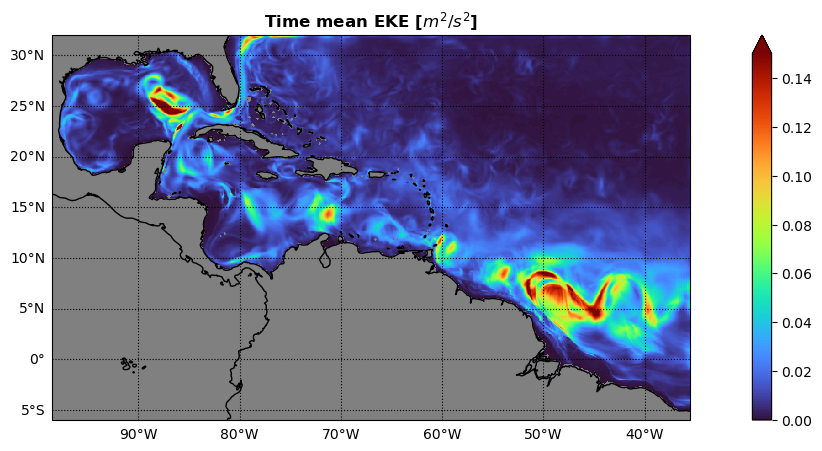

In [9]:
#--- some plot params to play with:
vmini = 0.0
vmaxi = 0.15
colormap = 'turbo'

#--- plot time mean EKE:
fig, axs = plt.subplots(ncols = 1,figsize=(16, 5),subplot_kw=dict(projection=ccrs.PlateCarree()))

c1 = EKE[:,:,:].mean(dim='time').plot.pcolormesh(vmin=vmini,vmax=vmaxi,cmap=colormap,transform=ccrs.PlateCarree(),add_colorbar = True,extend='max')

axs.coastlines(color='k')
axs.add_feature(cartopy.feature.LAND,color='gray')
axs.set_facecolor('gray')
axs.set_ylabel('')
axs.set_xlabel('')
axs.gridlines(color='k',linestyle=':',draw_labels=['left','bottom'], dms=True, x_inline=False, y_inline=False)
_ = axs.set_title('Time mean EKE [$m^{2}/s^{2}$]',fontweight ='bold')


## Prompt
Import GLORYS data for the same time period and calculate the mean EKE.\
Use xESMF to regrid both datasets to a common grid and compare the time mean EKE between CARIB12 and GLORYS.

What can you learn from comparing CARIB12 to the GLORYS reanalysis? \
How would it inform the development f the configuration?

# Temperature - Salinity Diagram

if using the original CARIB12 output, you do not need to change any paths or file names in this notebook. If you have configured and completed your own CARIB12 simulation you will need to update the paths and filenmae accordingly.

In [10]:
#--- load monthly mean 3D data of simulation to plot a T-S diagram:
ds = xr.open_dataset(parent_dir + 'CARIB_12.SMAG.001.mom6.hm.2017-09.nc',decode_timedelta=True)
ds

<xarray.Dataset> Size: 4GB
Dimensions:                         (time: 1, zl: 65, yh: 457, xq: 760,
                                     yq: 458, xh: 759, zi: 66, scalar_axis: 1,
                                     nbnd: 2)
Coordinates:
  * xq                              (xq) float64 6kB -98.5 -98.42 ... -35.5
  * yh                              (yh) float64 4kB -5.958 -5.875 ... 31.96
  * zl                              (zl) float64 520B 1.25 3.75 ... 5.876e+03
  * time                            (time) datetime64[ns] 8B 2017-09-14
  * nbnd                            (nbnd) float64 16B 1.0 2.0
  * xh                              (xh) float64 6kB -98.46 -98.38 ... -35.54
  * yq                              (yq) float64 4kB -6.0 -5.917 ... 31.92 32.0
  * zi                              (zi) float64 528B 0.0 2.5 ... 6e+03
  * scalar_axis                     (scalar_axis) float64 8B 0.0
Data variables: (12/65)
    uo                              (time, zl, yh, xq) float32 90MB ...
    vo                              (time, zl, yq, xh) float32 90MB ...
    h                               (time, zl, yh, xh) float32 90MB ...
    e                               (time, zi, yh, xh) float32 92MB ...
    thetao                          (time, zl, yh, xh) float32 90MB ...
    so                              (time, zl, yh, xh) float32 90MB ...
    ...                              ...
    opottempdiff                    (time, zl, yh, xh) float32 90MB ...
    frazil_heat_tendency            (time, zl, yh, xh) float32 90MB ...
    average_T1                      (time) datetime64[ns] 8B ...
    average_T2                      (time) datetime64[ns] 8B ...
    average_DT                      (time) timedelta64[ns] 8B ...
    time_bounds                     (time, nbnd) datetime64[ns] 16B ...
Attributes:
    NumFilesInSet:     1
    title:             MOM6 diagnostic fields table for CESM case: CARIB_12.S...
    associated_files:  area_t: CARIB_12.SMAG.001.mom6.static.nc
    grid_type:         regular
    grid_tile:         N/A

## Potential Density


In [ ]:
#--- Get mean temperature and salinity profiles to simplify calculations for the demo:
ptemp = ds['thetao'].mean(dim='time').mean(dim=['xh','yh'])
salt  = ds['so'].mean(dim='time').mean(dim=['xh','yh'])

## Prompt
The previous step does an area average without considering variation in the area of each cell. Repeat the previous step by implementing an area-weighted average computation.\
The following example could be applied to this notebook:

    weights = np.cos(np.deg2rad(data.lat))
    weights.name = "weights"
    data_weighted = data.weighted(weights)
    weighted_mean = data_weighted.mean(("lon", "lat"))

where "data" is a data array with dimensions "lon" and "lat" corresponding to longitudes and latitudes, respectively.

In [ ]:
#--- Compute sigma-theta (potential density anomaly, referenced to 0 dbar)
#--- Need Absolute Salinity and Conservative Temperature for GSW
Tgrid = np.linspace(ptemp.min()-0.5, ptemp.max()+0.5, 50)
Sgrid = np.linspace(salt.min()-0.1, salt.max()+0.1, 50)
Sg, Tg = np.meshgrid(Sgrid, Tgrid)

SA = gsw.SA_from_SP(Sg, p=0, lon=0, lat=0)
CT = gsw.CT_from_pt(SA, Tg)

sigma0 = gsw.sigma0(SA, CT) 

## Plot TS diagram with sigma contours

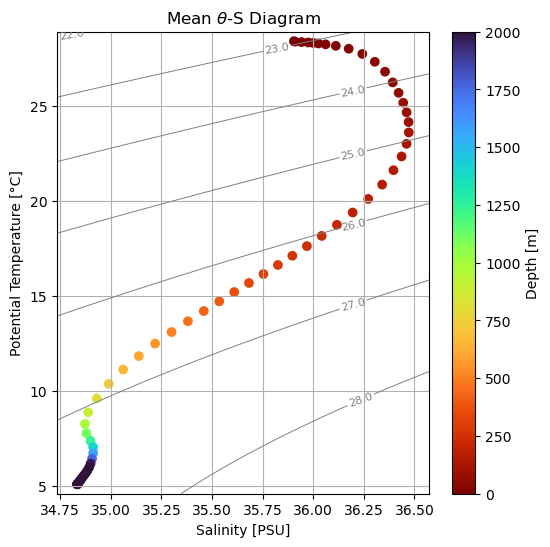

In [19]:
plt.figure(figsize=(6,6))

# Density contours
cs = plt.contour(Sg, Tg, sigma0, colors='gray', linewidths=0.7)
plt.clabel(cs, inline=True, fontsize=8, fmt="%.1f")

# Time- and space-mean profile colored by depth
sc = plt.scatter(salt, ptemp, c=ptemp['zl'], vmin=0,vmax=2000,cmap='turbo_r')
plt.colorbar(sc, label='Depth [m]')

plt.xlabel("Salinity [PSU]")
plt.ylabel("Potential Temperature [°C]")
plt.title("Mean " + r'$\theta$' +"-S Diagram")
plt.grid(True)
plt.show()

## Prompt
Repeat for GLORYS data and compare the vertical structure and water mass properties between the two datasets.

# Final Prompt

Leveraging what you've learned throughout the workshop and this notebook, can you incorporate a similar analysis into CUPiD?\
Good luck!